In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

pd.options.display.max_columns = 500
pd.options.display.max_rows = 5000

os.getcwd()
os.chdir('c:\\Users\\zach_\\Desktop\\Research\\Github\\RFE_project')

In [2]:
# load aggregate pattern
datapath = Path("data/cleaned/agg_pattern.h5")
df = pd.read_hdf(datapath, key = "data")

# print sector names
sectors = df['sector_2'].unique()
print(sectors)

[11 21 22 23 31 42 44 48 51 52 53 54 55 56 61 62 71 72 81]


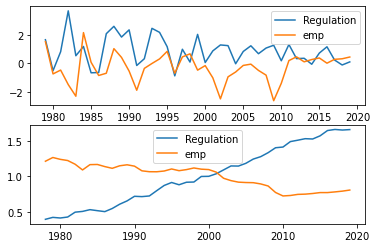

In [3]:
# plot sector regulation and variable correlation
df_sector = df[df.sector_2 == 31]
var = "emp"
x = df_sector.year
y1 = np.log(df_sector.industry_restrictions_2_0) - np.log(df_sector.industry_restrictions_2_0.shift(+1))
y1_normalized = y1/y1.std()
y1_long = (df_sector.industry_restrictions_2_0)
y1_long_normalized = y1_long/y1_long.mean()

y2 = (df_sector[var] - df_sector[var].shift(1))
y2_normalized = y2/y2.std()
y2_long = (df_sector[var])
y2_long_normalized = y2_long/y2_long.mean()

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(x, y1_normalized, label='Regulation')
ax1.plot(x, y2_normalized, label=var)
ax1.legend()

ax2.plot(x, y1_long_normalized, label='Regulation')
ax2.plot(x, y2_long_normalized, label=var)
ax2.legend()

In [10]:
from linearmodels.iv import IV2SLS

# load life path data
datapath_sec = Path("data/cleaned/data_final_sec.h5")
df = pd.read_hdf(datapath_sec, key="data")

datapath_sec_ag = Path("data/cleaned/sector_age_panel.h5")
df_ag = pd.read_hdf(datapath_sec_ag, key="data")

df_ag_raw = pd.read_csv("C:/Users/zach_/Nobackupfile/Data/BDS/bds2019_naics_4_age.csv")

datapath_sec_sz = Path("data/cleaned/data_final_sec_sz.h5")
df_sz = pd.read_hdf(datapath_sec_sz, key="data")

depend_vars = [
  "log_emp", "log_avg_emp", "job_creation_rate",
  "job_destruction_rate", "net_job_creation_rate",
  "reallocation_rate", "death_rate",
  "L_0_entry_rate"
  ]

In [12]:
df_ag_raw["firms"] = pd.to_numeric(df_ag_raw["firms"], errors="coerce", downcast=None)

In [17]:
df_ag[df_ag.firms == 0]
df_ag_raw[(df_ag_raw.sector == 1100) &(df_ag_raw.year == 1978) ]

,year,sector,fage,firms,estabs,emp,denom,estabs_entry,estabs_entry_rate,estabs_exit,estabs_exit_rate,job_creation,job_creation_births,job_creation_continuers,job_creation_rate_births,job_creation_rate,job_destruction,job_destruction_deaths,job_destruction_continuers,job_destruction_rate_deaths,job_destruction_rate,net_job_creation,net_job_creation_rate,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp
0,1978,1100,a) 0,3911.0,3919,16879,8440,3919,200,(X),(X),16879,16879,(X),200,200,(X),(X),(X),(X),(X),16879,200,(X),(X),(X),(X)
1,1978,1100,b) 1,3043.0,3075,16199,17413,15,0.402,1334,35.721,6004,101,5903,0.58,34.481,8346,5709,2637,32.787,47.931,-2342,-13.45,68.962,1019,1030,4821
2,1978,1100,c) 2,NaN,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,1978,1100,d) 3,NaN,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,1978,1100,e) 4,NaN,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
5,1978,1100,f) 5,NaN,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
6,1978,1100,g) 6 to 10,NaN,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
7,1978,1100,h) 11 to 15,NaN,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
8,1978,1100,i) 16 to 20,NaN,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
9,1978,1100,j) 21 to 25,NaN,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [79]:
# check lags
print(df.columns.tolist()[0:10])
df_test = df[(df.sector == 1100 ) & (df.year == 1985) ]

df_test1 = df_ag[(df_ag.sector == 1100 ) & (df_ag.year == 1985) ]

print(df_test.job_creation_rate)
print(df_test1.job_creation_rate.median())

['year', 'sector', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit', 'job_creation', 'job_destruction']
1967    0.27545
Name: job_creation_rate, dtype: float64
0.22655805736377616


### sector level

In [101]:
dict1 = {}
dict1["index"] = ["OLS Coef", "", "P Value", "# obs"]
for depend_var in depend_vars:
    # load data
    data = df

    # sample restriction
    data = data[(data.year > 1985)&(data.year < 2020)]

    # regression
    data = data.set_index(['sector', 'year'])
    
    var_lst = [
      "L_0_log_restriction_2_0",
      "L_0_log_gdp", "L_1_log_gdp",
      depend_var, "sector_2", "firms"
      ]
    
    formula_txt = f'{depend_var} ~ L_0_log_gdp + L_1_log_gdp + L_0_log_restriction_2_0 + EntityEffects + TimeEffects'
    
    # regression
    data1 = data.loc[:, var_lst].dropna()
    mod1 = PanelOLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1, drop_absorbed=True)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0"]
    for v_name in vnames:
        
        coefs_value = res.params[v_name][0]
        coefs_value = str(round(coefs_value, 5))
        std = res.std_errors[v_name]
        std = "[" + str(round(std, 5)) + "]"
        p_value = res.pvalues[v_name]
        stars = int(p_value < 0.01)*"*" + int(p_value < 0.05)*"*" + int(p_value < 0.1)*"*"
        coefs_value = coefs_value + stars
        p_value = str(round(p_value, 5))
        nobs = res.nobs
        dict1[f"{depend_var}"] =  [coefs_value, std, p_value, nobs]
    
df_coefs_age = pd.DataFrame(dict1)
df_coefs_age

IndexError: invalid index to scalar variable.

In [49]:
# iv estimation
temp_dict = []

for depend_var in depend_vars:
    # load data
    data = df

    # sample restriction
    data = data[(data.year > 1985)&(data.year < 2020)]

    var_list = [
      "L_0_log_restriction_2_0", "L_0_bartik_iv",
      "L_0_log_gdp", "L_1_log_gdp",
      depend_var, "sector_2", 'firms', "sector", "year"]
    
    formula_txt = f'{depend_var} ~ C(sector) + C(year) + L_0_log_gdp + L_1_log_gdp + [L_0_log_restriction_2_0 ~ L_0_bartik_iv]'
    
    # regression
    data1 = data.loc[:, var_list].dropna()
    mod1 = IV2SLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"depend_var": depend_var, "Coef": coefs_value,
                      "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                      "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
    
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var'])
df_coefs_age

,depend_var,Coef,std,lower_ci,upper_ci,p values,significance,# obs
7,L_0_entry_rate,-0.003224,0.012237,-0.027208,0.020760,7.921813e-01,False,8262
6,death_rate,0.035372,0.006182,0.023255,0.047489,1.056330e-08,True,8262
2,job_creation_rate,0.066522,0.013938,0.039205,0.093839,1.815823e-06,True,8262
3,job_destruction_rate,0.079474,0.014535,0.050987,0.107962,4.553885e-08,True,8262
1,log_avg_emp,-0.606577,0.132862,-0.866981,-0.346173,4.983720e-06,True,8262
0,log_emp,0.129415,0.106524,-0.079367,0.338198,2.244052e-01,False,8262
4,net_job_creation_rate,-0.012952,0.020305,-0.052750,0.026845,5.235519e-01,False,8262
5,reallocation_rate,0.152861,0.021958,0.109824,0.195898,3.366862e-12,True,8262


In [44]:
# first stage estimation
temp_dict = []

# load data
data = df

# sample restriction
data = data[(data.year > 1985)&(data.year < 2020)]

# regression
data = data.set_index(['sector', 'year'])

var_lst = [
  "L_0_log_restriction_2_0", "L_0_bartik_iv",
  "L_0_log_gdp", "L_1_log_gdp",
  "death_rate", "emp",
  'sector_2', depend_var, 'firms'
  ]

formula_txt = f'L_0_log_restriction_2_0 ~ + L_0_log_gdp + L_0_bartik_iv + EntityEffects + TimeEffects'
# regression
data1 = data.loc[:, var_lst].dropna()
mod1 = PanelOLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1, drop_absorbed=True)

res = mod1.fit(cov_type='heteroskedastic')

# results
vnames = ["L_0_bartik_iv"]
for v_name in vnames:
    dict1 = {}
    coefs_value = res.params[v_name]
    std = res.std_errors[v_name]
    lower_ci = res.conf_int().loc[v_name, "lower"]
    upper_ci = res.conf_int().loc[v_name, "upper"]
    p_value = res.pvalues[v_name]
    nobs = res.nobs
    sign = (lower_ci * upper_ci > 0)
    dict1.update({"depend_var": depend_var, "Coef": coefs_value,
                  "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                  "p values":p_value, "significance": sign, "# obs":nobs}) 
    temp_dict.append(dict1)

df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var'])
df_coefs_age

,depend_var,Coef,std,lower_ci,upper_ci,p values,significance,# obs
0,L_0_entry_rate,0.121934,0.008783,0.104716,0.139151,0.0,True,8262


### heterogeneity on sizes

In [71]:
df_sz.head()

,year,sector,large_firm,firms,estabs,emp,denom,estabs_entry,estabs_exit,job_creation,job_destruction,net_job_creation,firmdeath_firms,estabs_entry_rate,estabs_exit_rate,job_creation_rate,job_destruction_rate,net_job_creation_rate,reallocation_rate,death,log_emp,log_avg_emp,death_rate,sector_2,sector_3,sector_4,L_0_job_creation_rate,L_1_job_creation_rate,L_2_job_creation_rate,L_0_net_job_creation_rate,L_1_net_job_creation_rate,L_2_net_job_creation_rate,L_0_job_destruction_rate,L_1_job_destruction_rate,L_2_job_destruction_rate,L_0_estabs_exit,L_1_estabs_exit,L_2_estabs_exit,L_0_estabs_exit_rate,L_1_estabs_exit_rate,L_2_estabs_exit_rate,L_0_net_job_creation,L_1_net_job_creation,L_2_net_job_creation,L_0_estabs_entry_rate,L_1_estabs_entry_rate,L_2_estabs_entry_rate,L_0_reallocation_rate,L_1_reallocation_rate,L_2_reallocation_rate,L_0_death_rate,L_1_death_rate,L_2_death_rate,L_0_log_avg_emp,L_1_log_avg_emp,L_2_log_avg_emp,L_0_log_emp,L_1_log_emp,L_2_log_emp,L_0_emp,L_1_emp,L_2_emp,L_0_firms,L_1_firms,L_2_firms,job_creation_rate_chg,net_job_creation_rate_chg,job_destruction_rate_chg,estabs_exit_chg,estabs_exit_rate_chg,net_job_creation_chg,estabs_entry_rate_chg,reallocation_rate_chg,death_rate_chg,log_avg_emp_chg,log_emp_chg,emp_chg,firms_chg,L_0_year,L_0_industry_restrictions_2_0,L_0_bartik_iv,L_0_gdp,L_0_entry,L_0_incumbents,L_0_log_restriction_2_0,L_0_log_gdp,L_0_entry_rate,L_1_year,L_1_industry_restrictions_2_0,L_1_bartik_iv,L_1_gdp,L_1_entry,L_1_incumbents,L_1_log_restriction_2_0,L_1_log_gdp,L_1_entry_rate,L_2_year,L_2_industry_restrictions_2_0,L_2_bartik_iv,L_2_gdp,L_2_entry,L_2_incumbents,L_2_log_restriction_2_0,L_2_log_gdp,L_2_entry_rate,L_0_chg_log_restriction_2_0,L_0_chg_bartik_iv,L_0_chg_log_gdp,L_0_chg_log_emp,L_0_chg_entry_rate,L_0_emp_growth,L_1_chg_log_restriction_2_0,L_1_chg_bartik_iv,L_1_chg_log_gdp,L_1_chg_log_emp,L_1_chg_entry_rate,L_1_emp_growth
0,1978,11,0,23656.0,23949.0,167846.0,158632.0,4652.0,3927.0,56262.0,38029.0,18233.0,2875.0,0.194246,0.163973,0.354670,0.239731,0.114939,0.479462,2875.0,12.030802,1.959430,0.121534,11,11,11,0.354670,NaN,NaN,0.114939,NaN,NaN,0.239731,NaN,NaN,3927.0,NaN,NaN,0.163973,NaN,NaN,18233.0,NaN,NaN,0.194246,NaN,NaN,0.479462,NaN,NaN,0.121534,NaN,NaN,1.959430,NaN,NaN,12.030802,NaN,NaN,167846.0,NaN,NaN,23656.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978,30814.730707,4.780154,59.5,3909.0,19747.0,10.335748,4.085976,0.197954,1977,31077.971573,4.904169,51.2,NaN,NaN,10.344255,3.93574,NaN,1976,30411.171236,5.002512,50.1,NaN,NaN,10.322565,3.914021,NaN,-0.008506,-0.124015,0.150237,NaN,NaN,NaN,0.021689,-0.098343,0.021719,NaN,NaN,NaN
1,1978,11,1,123.0,475.0,31943.0,33515.0,57.0,42.0,5070.0,8295.0,-3225.0,0.0,0.120000,0.088421,0.151276,0.247501,-0.096226,0.302551,0.0,10.371708,5.559524,0.000000,11,11,11,0.151276,NaN,NaN,-0.096226,NaN,NaN,0.247501,NaN,NaN,42.0,NaN,NaN,0.088421,NaN,NaN,-3225.0,NaN,NaN,0.120000,NaN,NaN,0.302551,NaN,NaN,0.000000,NaN,NaN,5.559524,NaN,NaN,10.371708,NaN,NaN,31943.0,NaN,NaN,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978,30814.730707,4.780154,59.5,0.0,123.0,10.335748,4.085976,0.000000,1977,31077.971573,4.904169,51.2,NaN,NaN,10.344255,3.93574,NaN,1976,30411.171236,5.002512,50.1,NaN,NaN,10.322565,3.914021,NaN,-0.008506,-0.124015,0.150237,NaN,NaN,NaN,0.021689,-0.098343,0.021719,NaN,NaN,NaN
2,1978,21,0,18560.0,20151.0,289355.0,275648.0,3425.0,2658.0,90495.0,63062.0,27433.0,1698.0,0.169967,0.131904,0.328299,0.228777,0.099522,0.457555,1698.0,12.575410,2.746646,0.091487,21,21,21,0.328299,NaN,NaN,0.099522,NaN,NaN,0.228777,NaN,NaN,2658.0,NaN,NaN,0.131904,NaN,NaN,27433.0,NaN,NaN,0.169967,NaN,NaN,0.457555,NaN,NaN,0.091487,NaN,NaN,2.746646,NaN,NaN,12.575410,NaN,NaN,289355.0,NaN,NaN,18560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978,4643.326886,4.433029,50.4,2685.0,15875.0,8.443186,3.919991,0.169134,1977,2500.191415,4.369975,44.0,NaN,NaN,7.824123,3.78419,NaN,1976,3046.813993,4.210471,38.0,NaN,NaN,8.021852,3.637586,NaN,0.

In [74]:
# ols estimation
temp_dict = []

for depend_var in depend_vars:
    # load data
    data = df_sz

    # sample restriction
    data = data[(data.year > 1985)&(data.year < 2020)]

    # regression
    data = data.set_index(['sector', 'year'])
    
    var_lst = [
      "L_0_log_restriction_2_0",
      "L_0_log_gdp", "L_1_log_gdp",
      depend_var, "sector_2", "firms", "large_firm"
      ]
    
    formula_txt = f'{depend_var} ~ L_0_log_gdp + L_1_log_gdp + L_0_log_restriction_2_0 \
      +  L_0_log_restriction_2_0:large_firm + large_firm + \
        EntityEffects + TimeEffects'
    
    # regression
    data1 = data.loc[:, var_lst].dropna()
    mod1 = PanelOLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1, drop_absorbed=True)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0", "L_0_log_restriction_2_0:large_firm"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"depend_var": depend_var, "Coef": coefs_value,
                      "std":std, "v_name":v_name, "lower_ci": lower_ci, "upper_ci": upper_ci,
                      "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
    
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var', 'v_name'])
df_coefs_age

,depend_var,Coef,std,v_name,lower_ci,upper_ci,p values,significance,# obs
14,L_0_entry_rate,0.018109,0.004945,L_0_log_restriction_2_0,0.008403,0.027815,2.650851e-04,True,952
15,L_0_entry_rate,-0.003036,0.001494,L_0_log_restriction_2_0:large_firm,-0.005968,-0.000104,4.245927e-02,True,952
12,death_rate,0.009539,0.003014,L_0_log_restriction_2_0,0.003623,0.015454,1.605613e-03,True,952
13,death_rate,-0.002067,0.000807,L_0_log_restriction_2_0:large_firm,-0.003651,-0.000483,1.059098e-02,True,952
4,job_creation_rate,0.014037,0.004211,L_0_log_restriction_2_0,0.005772,0.022302,8.933034e-04,True,952
5,job_creation_rate,-0.007320,0.001596,L_0_log_restriction_2_0:large_firm,-0.010452,-0.004187,5.163702e-06,True,952
6,job_destruction_rate,0.018231,0.005556,L_0_log_restriction_2_0,0.007327,0.029135,1.072404e-03,True,952
7,job_destruction_rate,-0.006465,0.001633,L_0_log_restriction_2_0:large_firm,-0.009670,-0.003260,8.130121e-05,True,952
2,log_avg_emp,0.175211,0.022867,L_0_log_restriction_2_0,0.130331,0.220090,4.729550e-14,True,952
3,log_avg_emp,0.138434,0.027564,L_0_log_restriction_2_0:large_firm,0.084336,0.192531,6.158827e-07,True,952


In [77]:
# iv estimation
temp_dict = []

for depend_var in depend_vars:
    # load data
    data = df_sz

    # sample restriction
    data = data[(data.year > 1985)&(data.year < 2020)]

    var_list = [
      "L_0_log_restriction_2_0", "L_0_bartik_iv",
      "L_0_log_gdp", "L_1_log_gdp", "large_firm",
      depend_var, "sector_2", 'firms', "sector", "year"]
    
    formula_txt = f'{depend_var} ~ C(sector) + C(year) + L_0_log_gdp + L_1_log_gdp + large_firm \
      [L_0_log_restriction_2_0 + L_0_log_restriction_2_0:large_firm \
      ~ L_0_bartik_iv + L_0_bartik_iv:large_firm]'
    
    # regression
    data1 = data.loc[:, ].dropna()
    mod1 = IV2SLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0", "L_0_log_restriction_2_0:large_firm"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"depend_var": depend_var, "Coef": coefs_value, "v_name":v_name,
                      "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                      "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
    
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var'])
df_coefs_age

,depend_var,Coef,v_name,std,lower_ci,upper_ci,p values,significance,# obs
14,L_0_entry_rate,0.008748,L_0_log_restriction_2_0,0.016890,-0.024357,0.041853,6.045195e-01,False,952
15,L_0_entry_rate,-0.000234,L_0_log_restriction_2_0:large_firm,0.003648,-0.007385,0.006916,9.487828e-01,False,952
12,death_rate,0.039234,L_0_log_restriction_2_0,0.008402,0.022766,0.055702,3.018710e-06,True,952
13,death_rate,-0.000621,L_0_log_restriction_2_0:large_firm,0.002159,-0.004854,0.003611,7.735879e-01,False,952
4,job_creation_rate,0.018623,L_0_log_restriction_2_0,0.020953,-0.022444,0.059690,3.741108e-01,False,952
5,job_creation_rate,-0.022975,L_0_log_restriction_2_0:large_firm,0.005874,-0.034488,-0.011462,9.178068e-05,True,952
6,job_destruction_rate,0.026835,L_0_log_restriction_2_0,0.022695,-0.017646,0.071317,2.370340e-01,False,952
7,job_destruction_rate,-0.009600,L_0_log_restriction_2_0:large_firm,0.005808,-0.020984,0.001784,9.835334e-02,False,952
2,log_avg_emp,0.185666,L_0_log_restriction_2_0,0.104010,-0.018190,0.389522,7.424847e-02,False,952
3,log_avg_emp,0.185176,L_0_log_restriction_2_0:large_firm,0.073260,0.041589,0.328763,1.148266e-02,True,952


### heterogeneity on ages

In [8]:
# iv estimation
depend_vars = [
  "log_emp", "log_avg_emp", "job_creation_rate",
  "job_destruction_rate", "net_job_creation_rate",
  "reallocation_rate", "death_rate",
  ]

In [14]:
def plot_lp(v_name, df, depend_var, plot_name, fig_path, var_name, std):
    """
    plot_lp plot local projection graph
    Args:
        df [DataFrame]: Data contains coefs
        depend_var [str]: dependent variable
        plot_name [str]: name for the plot 
        var_names [lst]: lst of string of variable names
        fig_path [Path]: path of the figure
    Return:
        None
    """

    fig, ax = plt.subplots()
    depend_name = depend_var.replace("_", " ").title()

    df_sub = df[df.name == v_name]
    Age = df_sub.age.to_numpy().T
    Age = Age.astype(int)
    Coef = df_sub.Coef.to_numpy().T 
    Coef = Coef * std
    lower_ci = - df_sub[["lower_ci"]].to_numpy().T + df_sub.Coef.to_numpy().T 
    lower_ci  = lower_ci * std
    upper_ci = df_sub[["upper_ci"]].to_numpy().T - df_sub.Coef.to_numpy().T 
    upper_ci = upper_ci * std
    yerr = np.vstack((lower_ci, upper_ci))
    
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.scatter(Age, Coef)
    ax.errorbar(Age, Coef, yerr = yerr, fmt = 'o',color = 'orange', 
        ecolor = 'lightgreen', elinewidth = 3, capsize=5)   
    ax.axhline(y=0, color='r', linestyle=':')
    
    ax.set_title(f"{var_name}".title())
    ax.set_xlabel("Age")
    ax.set_ylabel(f"{depend_name}".title())
    
    fig.title(f'Effects of Regulation on {depend_name}')        
    fig.tight_layout()
    fig_final_path = fig_path/f"{plot_name}.png"
    fig.savefig(fig_final_path, facecolor='white', transparent=False)
    plt.close(fig)
    return None

In [13]:
# ols estimation
temp_dict = []
for depend_var in depend_vars:
    for age in df_ag.age_coarse.unique()[1:]:
        
        # load data
        data = df_ag[df_ag.age_coarse == age]

        # sample restriction
        data = data[data.year > 1985]

        # regression
        data = data.set_index(['sector', 'year'])

        var_lst = [
          "L_0_log_restriction_2_0",
          "L_0_entry_rate","L_0_log_gdp",
          'sector_2', depend_var, 'firms']
        
        formula_txt = f'{depend_var} ~ L_0_entry_rate   \
                                     + L_0_log_gdp    \
                                     + L_0_log_restriction_2_0 + EntityEffects + TimeEffects'
                                     
        # regression
        data1 = data.loc[:, var_lst].dropna()
        mod1 = PanelOLS.from_formula(formula = formula_txt, weights=data1['firms'], data = data1, drop_absorbed=True)

        res = mod1.fit(cov_type='heteroskedastic')

        # results
        vnames = ["L_0_log_restriction_2_0"]
        for v_name in vnames:
            dict1 = {}
            coefs_value = res.params[v_name]
            std = res.std_errors[v_name]
            lower_ci = res.conf_int().loc[v_name, "lower"]
            upper_ci = res.conf_int().loc[v_name, "upper"]
            p_value = res.pvalues[v_name]
            nobs = res.nobs
            sign = (lower_ci * upper_ci > 0)
            dict1.update({"depend_var": depend_var, "age": age, "Coef": coefs_value,
                          "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                          "p values":p_value, "significance": sign, "# obs":nobs}) 
            temp_dict.append(dict1)
            
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var', 'age'])
df_coefs_age





TypeError: cannot unpack non-iterable Figure object

<Figure size 432x288 with 0 Axes>

NameError: name 'var_name' is not defined

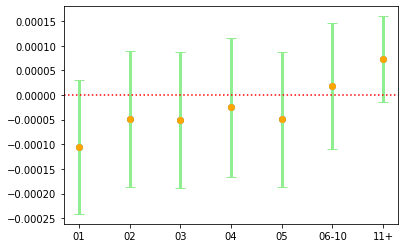

In [18]:
df = df_coefs_age
v_name = "log_emp"
fig, ax = plt.subplots()
depend_name = depend_var.replace("_", " ").title()

df_sub = df[df.depend_var == v_name]
Age = df_sub.age.to_numpy().T
Coef = df_sub.Coef.to_numpy().T 
Coef = Coef * std
lower_ci = - df_sub[["lower_ci"]].to_numpy().T + df_sub.Coef.to_numpy().T 
lower_ci  = lower_ci * std
upper_ci = df_sub[["upper_ci"]].to_numpy().T - df_sub.Coef.to_numpy().T 
upper_ci = upper_ci * std
yerr = np.vstack((lower_ci, upper_ci))

ax.scatter(Age, Coef)
ax.errorbar(Age, Coef, yerr = yerr, fmt = 'o',color = 'orange', 
    ecolor = 'lightgreen', elinewidth = 3, capsize=5)   
ax.axhline(y=0, color='r', linestyle=':')

ax.set_title(f"{var_name}".title())
ax.set_xlabel("Age")
ax.set_ylabel(f"{depend_name}".title())

fig.title(f'Effects of Regulation on {depend_name}')        
fig.tight_layout()

In [ ]:
vnames = ["L_0_log_restriction_2_0"]
plot_lp(v_names, df_coefs_age, depend_var, model_name, fig_path, var_names, std)

In [24]:
# IV 
import copy
from linearmodels.iv import IV2SLS

temp_dict = []
for depend_var in depend_vars:
    for age in df_ag.age_coarse.unique()[1:]:
        
        # load data
        data = df_ag[df_ag.age_coarse == age]

        # sample restriction
        data = data[(data.year > 1985) & (data.year < 2020)]

        var_lst = [
          "L_0_log_restriction_2_0", "L_0_bartik_iv", 
          "L_0_entry_rate",
          "L_0_log_gdp",
          "sector", "year",
           depend_var, "sector_2", 'firms'
           ]
        
        formula_txt = f'{depend_var} ~ C(year) + C(sector) \
                                     + L_0_entry_rate  \
                                     + L_0_log_gdp     \
                                     + [L_0_log_restriction_2_0 ~ L_0_bartik_iv]'
            
        # regression
        data1 = data.loc[:, var_lst].dropna()
        mod1 = IV2SLS.from_formula(
          formula = formula_txt, weights=data1['firms'], data = data1
        )

        res = mod1.fit(cov_type='heteroskedastic')

        # results
        vnames = ["L_0_log_restriction_2_0"]
        v_name = vnames[0]
        temp_dict = copy.deepcopy(temp_dict)
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"depend_var": depend_var, "age": age, "Coef": coefs_value,
                    "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                    "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
            
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['depend_var', 'age'])
df_coefs_age

,depend_var,age,Coef,std,lower_ci,upper_ci,p values,significance,# obs
42,death_rate,01,0.083167,0.021466,0.041094,0.125240,1.069063e-04,True,8129
43,death_rate,02,0.099839,0.015128,0.070189,0.129489,4.121814e-11,True,8102
44,death_rate,03,0.097283,0.012875,0.072048,0.122517,4.152234e-14,True,8097
45,death_rate,04,0.084297,0.012143,0.060497,0.108096,3.863354e-12,True,8082
46,death_rate,05,0.055501,0.011579,0.032806,0.078196,1.642609e-06,True,8061
47,death_rate,06-10,0.038679,0.007628,0.023729,0.053629,3.959701e-07,True,8188
48,death_rate,11+,0.019280,0.005206,0.009077,0.029482,2.125311e-04,True,8262
14,job_creation_rate,01,0.081854,0.026514,0.029888,0.133821,2.020504e-03,True,8129
15,job_creation_rate,02,0.058557,0.023878,0.011756,0.105358,1.419467e-02,True,8102
16,job_creation_rate,03,0.002862,0.021651,-0.039573,0.045297,8.948319e-01,False,8097


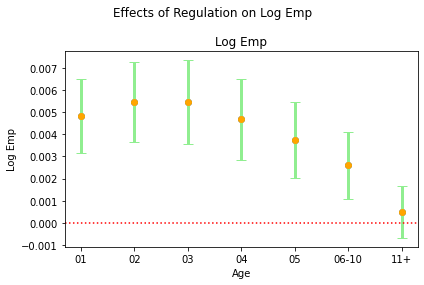

In [20]:
df = df_coefs_age
depend_var = "log_emp"
fig, ax = plt.subplots()
depend_name = depend_var.replace("_", " ").title()

df_sub = df[df.depend_var == depend_var]
Age = df_sub.age.to_numpy().T
Coef = df_sub.Coef.to_numpy().T 
Coef = Coef * std
lower_ci = - df_sub[["lower_ci"]].to_numpy().T + df_sub.Coef.to_numpy().T 
lower_ci  = lower_ci * std
upper_ci = df_sub[["upper_ci"]].to_numpy().T - df_sub.Coef.to_numpy().T 
upper_ci = upper_ci * std
yerr = np.vstack((lower_ci, upper_ci))

ax.scatter(Age, Coef)
ax.errorbar(Age, Coef, yerr = yerr, fmt = 'o',color = 'orange', 
    ecolor = 'lightgreen', elinewidth = 3, capsize=5)   
ax.axhline(y=0, color='r', linestyle=':')

ax.set_title(f"{depend_name}".title())
ax.set_xlabel("Age")
ax.set_ylabel(f"{depend_name}".title())

fig.suptitle(f'Effects of Regulation on {depend_name}')        
fig.tight_layout()
#fig_final_path = fig_path/f"{plot_name}_{depend_name}.png"

#fig.savefig(fig_final_path, facecolor='white', transparent=False)
#plt.close(fig)

In [61]:
# FIRST STAGE
from linearmodels.iv import IV2SLS

temp_dict = []
for age in df_ag.age_coarse.unique()[1:]:
    
    # load data
    data = df_ag[df_ag.age_coarse == age]

    # sample restriction
    data = data[(data.year > 1985) & (data.year < 2020)]

    var_lst = [
        "L_0_log_restriction_2_0", "L_0_bartik_iv", 
        "L_0_entry_rate",
        "L_0_log_gdp",
        "sector", "year",
          depend_var, "sector_2", 'firms'
          ]
        
    formula_txt = f'L_0_log_restriction_2_0 ~ C(year) + C(sector) \
                                  + L_0_entry_rate  \
                                  + L_0_log_gdp     \
                                  + [L_0_bartik_iv ~ L_0_bartik_iv]'
    # regression
    data1 = data.loc[:, var_lst].dropna()
        
    mod1 = IV2SLS.from_formula(
      formula = formula_txt, weights=data1['firms'], data = data1
    )

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_bartik_iv"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"name": v_name, "age": age, "Coef": coefs_value,
                      "std":std, "lower_ci": lower_ci, "upper_ci": upper_ci,
                      "p values":p_value, "significance": sign, "# obs":nobs}) 
        temp_dict.append(dict1)
        
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['name', 'age'])
df_coefs_age

,name,age,Coef,std,lower_ci,upper_ci,p values,significance,# obs
0,L_0_bartik_iv,01,0.118351,0.007551,0.103550,0.133151,0.0,True,8129
1,L_0_bartik_iv,02,0.119706,0.007673,0.104668,0.134745,0.0,True,8102
2,L_0_bartik_iv,03,0.120833,0.007858,0.105432,0.136234,0.0,True,8097
3,L_0_bartik_iv,04,0.119831,0.008119,0.103918,0.135743,0.0,True,8082
4,L_0_bartik_iv,05,0.119854,0.008200,0.103781,0.135926,0.0,True,8061
5,L_0_bartik_iv,06-10,0.121440,0.008626,0.104533,0.138346,0.0,True,8188
6,L_0_bartik_iv,11+,0.124712,0.008830,0.107405,0.142020,0.0,True,8262


In [48]:
# pooled data
# load data
depend_var = "log_avg_emp"
data = df[df.age_coarse != "00"]

# sample restriction
data = data[(data.year > 1985) & (data.year < 2020)]

# regression
data1 = data.loc[:, ["L_0_log_restriction_2_0", "L_1_log_restriction_2_0", "L_0_log_restriction_2_0_init",
                        "L_0_entry_rate_whole", "L_1_entry_rate_whole", "L_2_entry_rate_whole", "L_3_entry_rate_whole",
                        "L_0_log_gdp", "L_1_log_gdp", "L_2_log_gdp", "L_3_log_gdp",
                        "death_rate", "age_coarse", "emp", "year", "sector",
                        'sector_2', depend_var, 'firms']].dropna()
mod1 = IV2SLS.from_formula(formula = f'{depend_var} ~ C(age_coarse) + C(year) + C(sector) \
                                        + L_0_entry_rate_whole  \
                                        + L_0_log_gdp  \
                                        + [L_0_log_restriction_2_0:C(age_coarse) ~ L_0_log_restriction_2_0_init:C(age_coarse) ]',
                                        weights=data1['firms'], data = data1)

res = mod1.fit(cov_type='heteroskedastic')
res.summary;

In [3]:
# create shift share

In [4]:
def lag_variable(df, time_var, id_var, var, lags):
    """
    lag_variable create lag variables by groups   
    Args:
        df [DataFrame]: dataframe
        time_var [lst]: time variable
        id_var [list of string]: id variable
        var [lst]: lagged varible
        lags: number of lags (1 means one lag)
    """

    index_var = time_var + id_var

    df = df.set_index(index_var)
    df_shift = df[var]
    
    shifted = df_shift.groupby(level=id_var).shift(lags)
    shifted = shifted.rename(columns={var[0]: f"L_{lags}_{var[0]}"})
    df = df.join(shifted)
    df = df.reset_index()
    
    return df

In [5]:
# load regulation data
df_doc = pd.read_csv("C:\\Users\\zach_\\Nobackupfile\\Data\\BDS\\Regdata\\regdata_4_0_documents.csv")
df_ind = pd.read_csv("C:\\Users\\zach_\\Nobackupfile\\Data\\BDS\\Regdata\\regdata_4_0_documents_2digit_naics.csv")

# clean variables
baseline_year = 1986
df_doc["year"] = pd.to_numeric(df_doc.year.str.slice(0,4))
df_ind["year"] = pd.to_numeric(df_ind.year.str.slice(0,4))

# create lag variable
df_doc = lag_variable(df_doc, ["year"], ["document_reference"], ["restrictions_2_0"], 1)

# create current measure
doc_var = ["year", "document_reference", "restrictions_1_0","restrictions_2_0", "L_1_restrictions_2_0"]
df_merge = df_ind.merge(df_doc[doc_var], how='left', on=["year", "document_reference"], validate="many_to_one")

df_init = df_merge.loc[df_merge.year == baseline_year, ["NAICS", "probability", "document_reference", "restrictions_2_0"]]
df_init = df_init.rename(columns = {"probability": "probability_init"})

In [6]:
df_init.tail()

,NAICS,probability_init,document_reference,restrictions_2_0
631048,54,0.9997,"Title 9, Part 97",12.0
631049,71,0.0310,"Title 9, Part 97",12.0
631050,44,0.0033,"Title 9, Part 98",26.0
631051,54,1.0000,"Title 9, Part 98",26.0
631052,62,0.0021,"Title 9, Part 98",26.0


In [7]:
df_init["reg_s_d_init"] = df_init["probability_init"] * df_init["restrictions_2_0"]
df_init["reg_s_init"] = df_init.groupby(["NAICS"])["reg_s_d_init"].transform(lambda x: x.sum())
df_init["share_init"] = np.where(df_init["reg_s_d_init"]>0, df_init["reg_s_d_init"] / df_init["reg_s_init"], 0) 
init_var = ["NAICS", "document_reference", "reg_s_d_init", "reg_s_init", "share_init"]
df_merge = df_merge.merge(df_init[init_var], how='left', on=["NAICS", "document_reference"], validate="many_to_one")

In [8]:
for var in ["reg_s_d_init", "reg_s_init", "share_init"]:
    df_merge[var] = np.where(df_merge[var].isna(), 0, df_merge[var])

df_merge[df_merge.year > 1988].head()

,year,document_reference,industry_description,NAICS,probability,restrictions_1_0,restrictions_2_0,L_1_restrictions_2_0,reg_s_d_init,reg_s_init,share_init
727392,1989,"Title 1, Part 10",Retail Trade,44,0.0023,4.0,8.0,8.0,0.0078,26240.771135,2.972474e-07
727393,1989,"Title 1, Part 10",Transportation and Warehousing,48,0.0040,4.0,8.0,8.0,0.0738,93757.179477,7.871397e-07
727394,1989,"Title 1, Part 10",Information,51,0.0063,4.0,8.0,8.0,0.0348,38345.618443,9.075352e-07
727395,1989,"Title 1, Part 10",Public Administration,92,0.0040,4.0,8.0,8.0,0.0180,26481.037613,6.797317e-07
727396,1989,"Title 1, Part 11",Agriculture Forestry Fishing and Hunting,11,0.0012,0.0,0.0,7.0,0.0000,0.000000,0.000000e+00


In [9]:
df_merge["reg_s_d"] = df_merge["probability"] * df_merge["restrictions_2_0"]
df_merge["reg_s"] = df_merge.groupby(["NAICS", "year"])["reg_s_d"].transform(lambda x: x.sum())
df_merge["share"] = np.where(df_merge["reg_s_d"] > 0, df_merge["reg_s_d"] / df_merge["reg_s"], 0) 
df_merge["log_reg_s_d"] = np.where(df_merge["reg_s_d"] > 0, np.log(df_merge["reg_s_d"]), 0)
df_merge["log_reg_d"] = np.where(df_merge["restrictions_2_0"] > 0, np.log(df_merge["restrictions_2_0"]), np.nan) 

c:\Users\zach_\.virtualenvs\RFE_project-5yjSZlxr\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\zach_\.virtualenvs\RFE_project-5yjSZlxr\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
df_merge["bartik_iv"] = df_merge["log_reg_d"] * df_merge["share_init"]
df_merge["industry_restrictions_2_0"] = df_merge["reg_s_d"]

In [12]:
regdata = df_merge.groupby(by=["year", "NAICS"])[["industry_restrictions_2_0", "bartik_iv"]].sum()

In [13]:
regdata["log_restrictions_2_0"] = np.log(regdata["industry_restrictions_2_0"])

In [14]:
regdata = regdata.reset_index()

In [15]:
regdata[regdata.year > 1985].corr()

,year,NAICS,industry_restrictions_2_0,bartik_iv,log_restrictions_2_0
year,1.000000e+00,-1.784297e-15,0.261905,-0.503649,0.245143
NAICS,-1.784297e-15,1.000000e+00,-0.150709,-0.214505,-0.052650
industry_restrictions_2_0,2.619046e-01,-1.507094e-01,1.000000,0.202504,0.861408
bartik_iv,-5.036486e-01,-2.145053e-01,0.202504,1.000000,0.177918
log_restrictions_2_0,2.451432e-01,-5.264981e-02,0.861408,0.177918,1.000000


In [ ]:

ind_init_var = ["document_reference", "NAICS", "probability_init"]
df_merge = df_merge.merge(df_ind_init[ind_init_var], how='left', on=["document_reference", "NAICS"], validate="many_to_one")

df_merge["industry_restrictions_2_0"] = df_merge["restrictions_2_0"]*df_merge["probability"]

df_merge["industry_restrictions_2_0_init"] = df_merge["restrictions_2_0"]*df_merge["probability_init"]
df_merge["industry_restrictions_1_0"] = df_merge["restrictions_1_0"]*df_merge["probability"]
df_merge["industry_restrictions_1_0_init"] = df_merge["restrictions_1_0"]*df_merge["probability_init"]
df_merge["industry_restrictions_2_0_chg"] = (df_merge["restrictions_2_0"] - df_merge["L_1_restrictions_2_0"]) * df_merge["probability"]
df_merge["industry_restrictions_2_0_log_chg"] = (np.log(df_merge["restrictions_2_0"]) - np.log(df_merge["L_1_restrictions_2_0"]))*df_merge["probability"]
df_merge["industry_restrictions_2_0_chg_init"] = (df_merge["industry_restrictions_2_0"] - df_merge["L_1_restrictions_2_0"])*df_merge["probability_init"]
df_merge["industry_restrictions_2_0_log_chg_init"] = (np.log(df_merge["restrictions_2_0"]) - np.log(df_merge["L_1_restrictions_2_0"]))*df_merge["probability_init"]

regdata = df_merge.groupby(by=["year", "NAICS"])[["industry_restrictions_2_0", "industry_restrictions_2_0_init",
                                                    "industry_restrictions_2_0_chg", "industry_restrictions_2_0_chg_init",
                                                    "industry_restrictions_2_0_log_chg", "industry_restrictions_2_0_log_chg_init",
                                                    "industry_restrictions_1_0", "industry_restrictions_1_0_init"]].sum()
regdata = regdata.reset_index()
regdata = regdata.rename(columns={"NAICS":"sector_reg"})

In [74]:
regdata.tail()

,year,sector_reg,industry_restrictions_2_0,industry_restrictions_2_0_init,industry_restrictions_2_0_chg,industry_restrictions_2_0_chg_init,industry_restrictions_2_0_log_chg,industry_restrictions_2_0_log_chg_init,industry_restrictions_1_0,industry_restrictions_1_0_init
760,2020,56,107867.302758,9049.477306,168.497903,-4329.503479,NaN,NaN,87652.348682,7303.644605
761,2020,61,55513.459184,15308.727287,-714.244803,-4970.627296,NaN,-2.535927,43429.542971,11283.113041
762,2020,62,45732.585166,5024.633055,589.208302,-1614.109635,NaN,NaN,34586.028448,3957.571966
763,2020,71,27123.132657,4498.939822,-51.714301,-3992.251101,NaN,-0.016242,21568.927742,3784.743419
764,2020,92,29069.286975,7284.200702,-138.966097,-5530.418561,NaN,NaN,23710.398266,5937.792602


In [71]:
df_ind.sort_values(["year", "NAICS"])
df_merge = df_ind.merge(df_doc[["year", "document_reference", "restrictions_2_0"]], how='left', on=["year", "document_reference"], validate="many_to_one")
df_merge["year_init"] = df_merge["year"] - 15
df_merge = df_merge.merge(df_ind_init[["year_init", "document_reference", "NAICS", "probability_init"]], how='left', on=["year_init", "document_reference", "NAICS"], validate="many_to_one")

In [72]:
df_merge["weight_index"] = df_merge["restrictions_2_0"]*df_merge["probability"]
df_merge["weight_index_init"] = df_merge["restrictions_2_0"]*df_merge["probability_init"]

In [77]:
df_merge.tail()

,year,document_reference,industry_description,NAICS,probability,restrictions_2_0,year_init,probability_init,weight_index,weight_index_init
2404407,2020,"Title 9, Part 99",Transportation and Warehousing,48,0.1006,2.0,2005,0.0581,0.2012,0.1162
2404408,2020,"Title 9, Part 99",Information,51,0.0019,2.0,2005,0.0028,0.0038,0.0056
2404409,2020,"Title 9, Part 99",Finance and Insurance,52,0.0014,2.0,2005,0.0039,0.0028,0.0078
2404410,2020,"Title 9, Part 99",Professional Scientific and Technical Services,54,0.0208,2.0,2005,0.0265,0.0416,0.0530
2404411,2020,"Title 9, Part 99",Public Administration,92,0.0716,2.0,2005,0.0290,0.1432,0.0580


In [73]:
df = df_merge.groupby(by=["year", "NAICS"])[["weight_index", "weight_index_init"]].sum()
df = df.reset_index()

In [68]:
df_merge[(df_merge._merge == "left_only") & (df_merge.industry_description == "Wholesale Trade")].head()

AttributeError: 'DataFrame' object has no attribute '_merge'

In [ ]:
df.head()